In [1]:
# Import statements and notebook settings
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

show_mnist_plots = True

In [46]:
# Plotting functions
def plot_heat_map(coef_arr, lambda_labels, fig_size_x=12, fig_size_y=12):
    """Plot heat maps (plural) for all coef in coef_arr

    Args:
        coef_arr (List[np.array]): List of 2D np arrays containing coef to plot
        lambda_labels (List[float]): List of lambda values to label plots. Must have length equal to coef_arr
    """
    plt.rcParams['figure.figsize'] = [fig_size_x, fig_size_y]
    if isinstance(coef_arr, (list)) is False:
        coef_arr = [coef_arr]
    if isinstance(lambda_labels, (list)) is False:
        lambda_labels = [lambda_labels]

    fig,axs = plt.subplots(len(lambda_labels),1)
    if len(lambda_labels) == 1:
        axs = [axs]
    for j, coef in enumerate(coef_arr):
        # x = coef.coef_
        x_pcolor = axs[j].pcolor(coef,cmap='hot')
        fig.colorbar(x_pcolor, ax=axs[j])
        axs[j].set_ylabel(f"lambda={lambda_labels[j]}") 
    return


def plot_confusion(model_coef, test_data, test_label, lambda_val, comp_factor=0, fig_size=12):
    plt.rcParams['figure.figsize'] = [fig_size, fig_size*0.8]
    pred = test_data@model_coef.T
    
    conf_pred = np.argmax(pred, axis=1)
    conf_mat = confusion_matrix(test_label, conf_pred, normalize='pred')
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    title = f"Lambda = {lambda_val}"
    if comp_factor:
        title = title + f"; Compression = {comp_factor:.2f}%"
    plt.title(title)
    plt.show()
    return


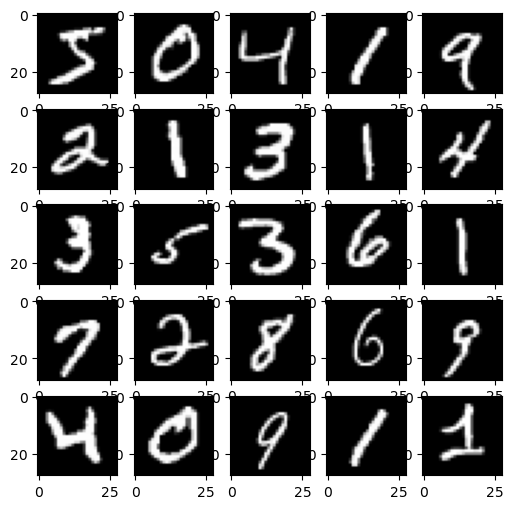

In [3]:
# Import MNIST data and vectorize it
fig_size = 6
plt.rcParams['figure.figsize'] = [fig_size,]

(train_data, train_label), (test_data, test_label) = mnist.load_data()

if show_mnist_plots:
    mnist_plots = (5)**2     # set to be squared number
    root_mnist = int(np.sqrt(mnist_plots))
    fig, axs = plt.subplots(root_mnist, root_mnist)
    for i in range(mnist_plots):
        axs[i//root_mnist, i%root_mnist].imshow(train_data[i], cmap=plt.get_cmap('gray'))
    plt.show()

num_labels = 10     # set equal to number of labels (digits)

def one_hot(labels, num_labels):
    # return array of one-hot encoding to match number of labels
    return np.eye(num_labels)[np.array(labels).reshape(-1)]

def vectorize_data(data, label, num_labels):
    # flatten each image in data into 1D array and create one-hot encoding result matrix
    data_vector = data.reshape(data.shape[0], -1)
    label_vector = one_hot(label, num_labels)
    return data_vector, label_vector

train_A, train_B = vectorize_data(train_data, train_label, num_labels)
test_A, test_B = vectorize_data(test_data, test_label, num_labels)

iter 0: lambda = 0.0001	252.68 sec	non-zero elem: 6730	iterations: 741.1
iter 1: lambda = 0.01	89.38 sec	non-zero elem: 4095	iterations: 339.6
iter 2: lambda = 0.1	45.46 sec	non-zero elem: 2246	iterations: 218.9
iter 3: lambda = 0.5	33.87 sec	non-zero elem: 1182	iterations: 200.0


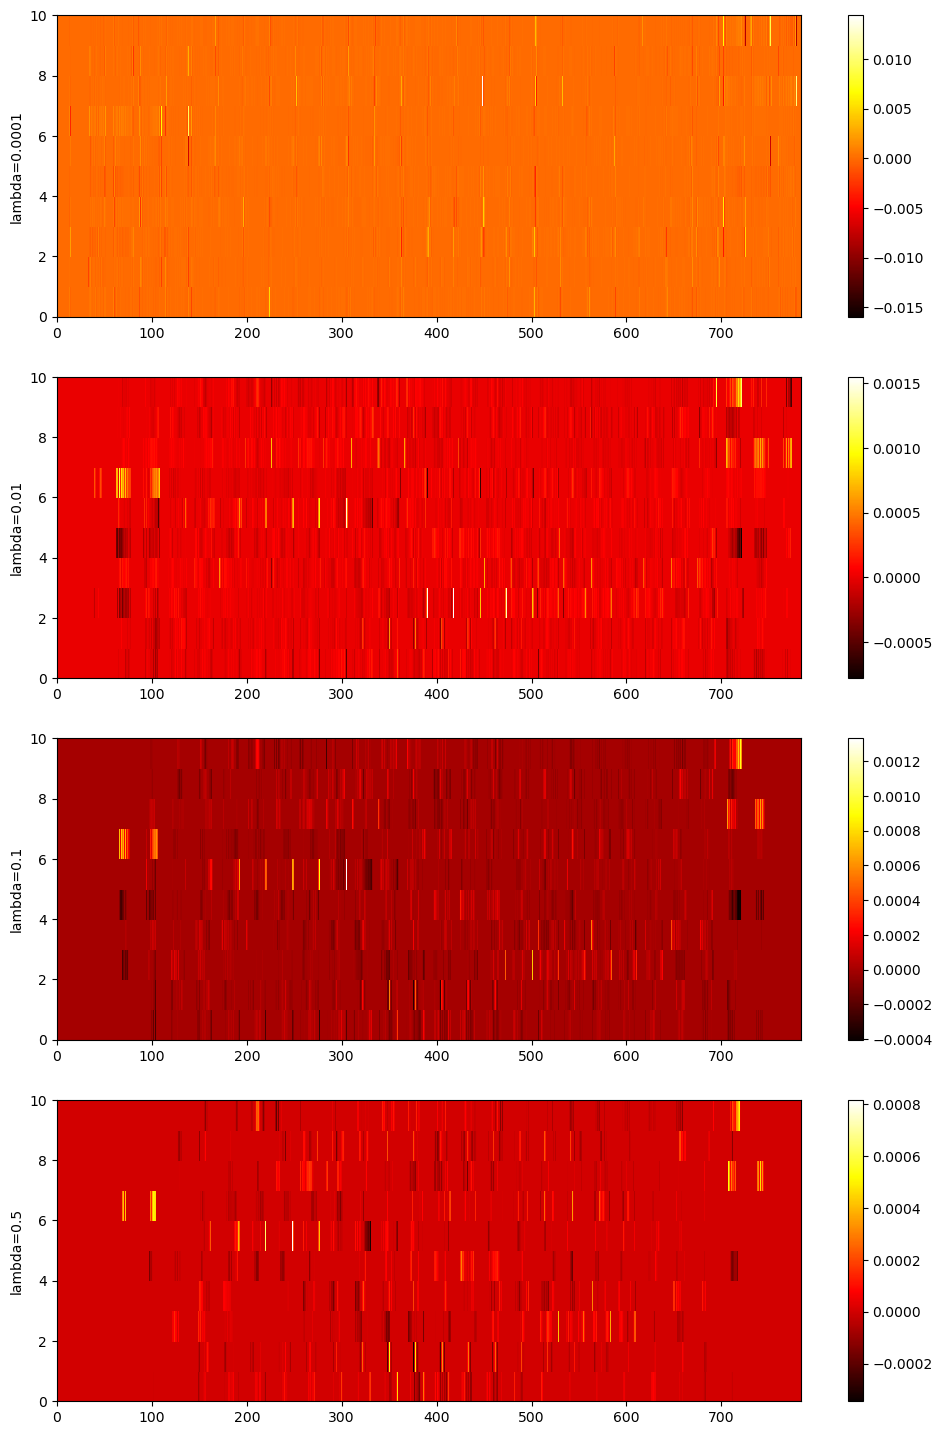

In [36]:
# solve AX=B to find pixels that map to correct label outcome and plot heat maps of coefficients

# lambda is regularization factor in Lasso algo
lambda_array = [1e-4, 1e-2, 1e-1, 0.5]

def generate_models(A, b, lambda_array):
    model_list = []
    for i, lam in enumerate(lambda_array):
        start = time.time()
        if lam==0:
            clf = linear_model.LinearRegression(fit_intercept=False)
        else:
            clf = linear_model.Lasso(alpha=lam, 
                                     fit_intercept=False, 
                                     warm_start=True, 
                                     selection='random',
                                    #  max_iter=200
                                     )
        clf.fit(A, b)
        elapsed = time.time() - start
        print(f"iter {i}: lambda = {lam}\t"
              f"{elapsed:.1f} sec\t"
              f"non-zero elem: {np.count_nonzero(clf.coef_)}\t"
              f"iterations: {np.average(clf.n_iter_)}")
        model_list.append(clf)
    return model_list

clf_array = generate_models(train_A, train_B, lambda_array)

plot_heat_map([model.coef_ for model in clf_array], lambda_array, fig_size_y=18)

plt.show()

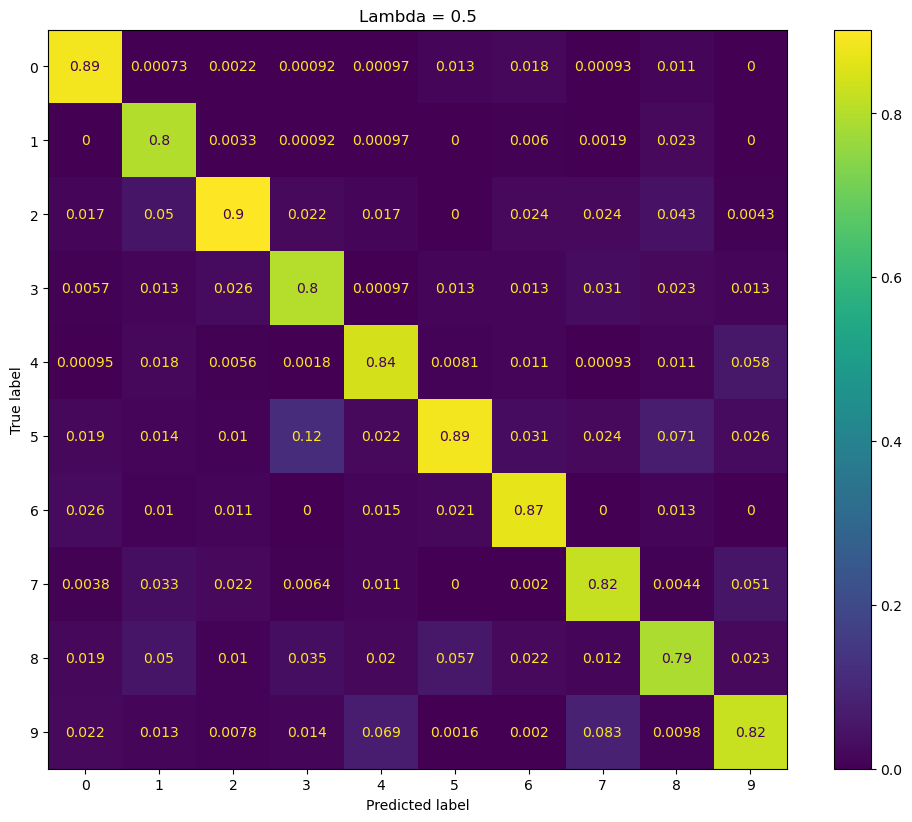

In [63]:
# Confusion matrix for selected lambda
model_ind = 3
lambda_val = lambda_array[model_ind]
model = clf_array[model_ind]
model_coef = model.coef_
plot_confusion(model_coef, test_A, test_label, lambda_val)


# of non-zero elements in base model: 1182
# of non-zero elements in compressed model: 796


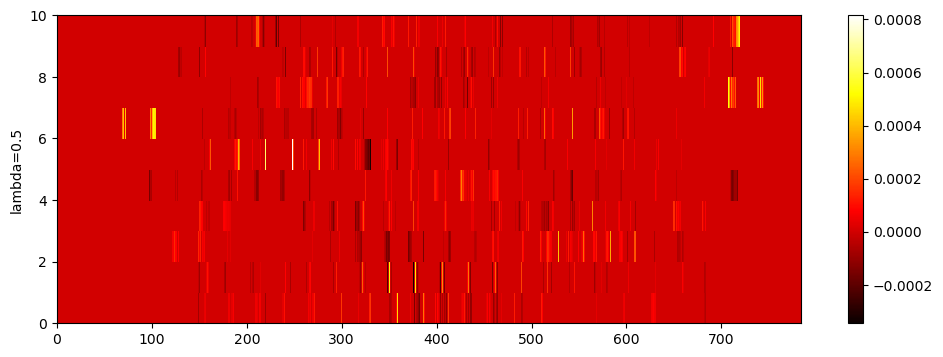

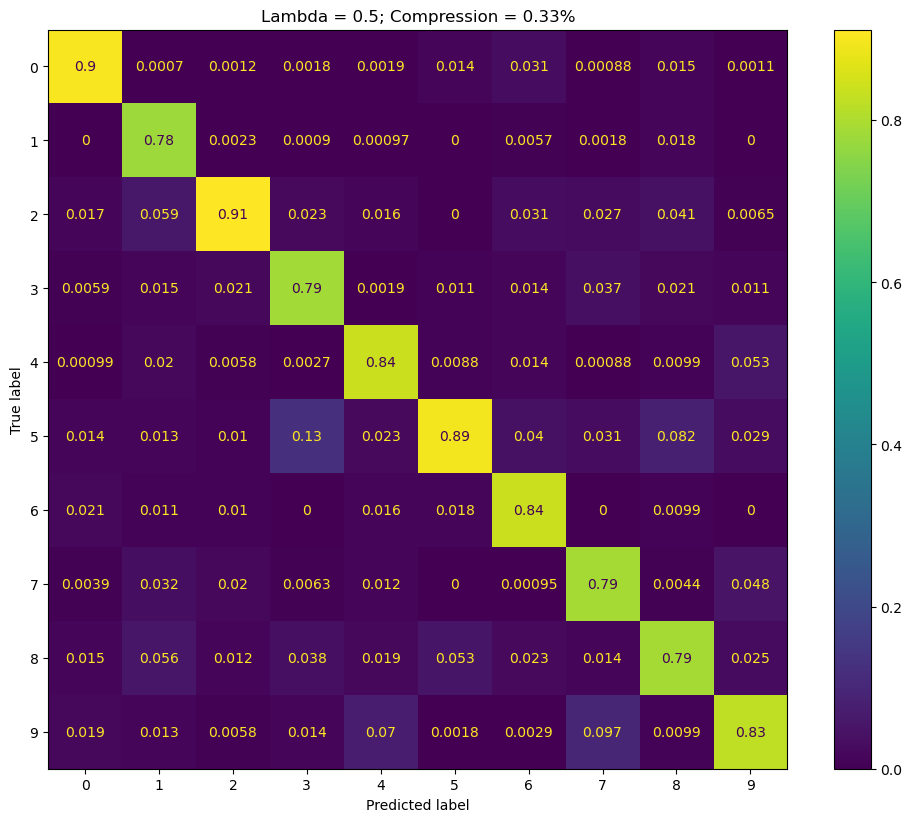

In [66]:
# Compress model for selected lambda
def compress_model(coef,threshold):
    """compress model by zeroing all coefficients below threshold, 
    where the threshold is defined as the percentage of the max coef
    """
    
    threshold_val = coef.max()*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val] = 0
    return comp_coef

def compress_model_by_row(coef,threshold):
    """compress model by zeroing all coefficients below threshold by row, 
    where the threshold is defined as the percentage of the max coef per row
    """
    threshold_val = coef.max(axis=1)*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val[:, np.newaxis]] = 0
    return comp_coef

def disp_comp_model_stats(base_model, comp_model, lambda_val):
    base_elem = np.count_nonzero(base_model)
    comp_model_elem = np.count_nonzero(comp_model)
    print(f"# of non-zero elements in compressed model: {comp_model_elem}")
    plot_heat_map(comp_model, lambda_val, fig_size_y=4)
    comp_factor = 1 - comp_model_elem/base_elem
    plot_confusion(comp_model, test_A, test_label, lambda_val, comp_factor=comp_factor)

base_elem = np.count_nonzero(model_coef)
print(f"# of non-zero elements in base model: {base_elem}")

threshold = 0.035
comp_model_abs = compress_model(model_coef, threshold)
disp_comp_model_stats(model_coef, comp_model_abs, lambda_val)
# comp_model_by_row = compress_model_by_row(model_coef, 2*threshold)
# disp_comp_model_stats(model_coef, comp_model_by_row, lambda_val)



